<h1>Inference using UNET</h1>

Prerequisites:
- Google Drive account with the preprocessed images to predict
- GPU ("Runtime"-->"Change Runtime Type")

**Input:** Preprocessed GeoTiff images, 15 bands, 300x300 pixels and matching masks

**Output:** a directory with predicted 300x300px 1 band masks with 3 classes (0,1,2):
- 0: 0 Other
- 1: 250 NonResi
- 2: 255 Resi

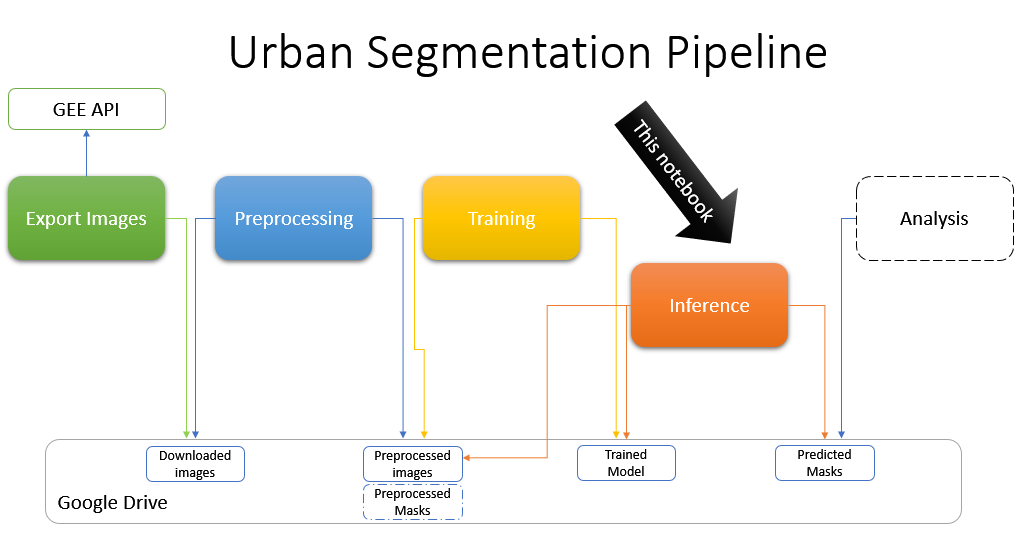

## Running instructions



1.   Connect to the NB
2.   Upload the ssh keys file on "Files" left side panel
3.   Update the preprocessed images and masks **parent path** in "REMOTE_EXPORT_DIR" in the next cell (images and masks will be copied locally to the NB directory "LOCAL_EXPORT_DIR")
4.   Run the notebook to train the model and perdict test masks
5. If you want to fine tune a trained model see the ["TRAINING - Hyperparams"](https://colab.research.google.com/drive/1Nt8iQDTHr39qFqpO36aN38tasQSSLzyZ?authuser=1#scrollTo=TRAINING_Hyperparams) section in this NB

In [1]:
#TODO >>>>>>>>>> CHANGE TO THE PREPROCESSED IMAGES AND MASKS PARENT DIRECTORY
REMOTE_EXPORT_DIR='/content/drive/MyDrive/gee_export_Jul_14_2022_1601_prep/'
LOCAL_EXPORT_DIR='/content/'
#TODO >>>>>>>>>> CHANGE if you want your trained model to be saved elsewhere
TRAINED_MODEL_REMOTE_PATH = REMOTE_EXPORT_DIR + '../models/'

#TODO >>>>>>>>>> CHANGE to True in order to backup predictions to a drive path
BACKUP=False
REMOTE_TARGET_PREDS_DIR=REMOTE_EXPORT_DIR + '/../'

## Setup

Upload the Git credentials files on the left files panel (if using a secured)Git repo

Alternatively you can download the [Urban Segmentation Git](https://github.com/lleviraz/urban_segmentation) Repo as ZIP file, then upload and extract here 

In [2]:
import os
if(not os.path.exists('urban_segmentation')):
  if(os.path.exists('/root/.ssh')):
    !mv -f /root/.ssh /root/.ssh_old
  !unzip gitssh.zip && mv .ssh /root/ && chmod -R 400 /root/.ssh && ls /root/.ssh
  !git clone git@github.com:lleviraz/urban_segmentation.git

Archive:  gitssh.zip
   creating: .ssh/
  inflating: .ssh/id_ed25519         
 extracting: .ssh/id_ed25519.pub     
  inflating: .ssh/id_rsa             
  inflating: .ssh/id_rsa.pub         
  inflating: .ssh/known_hosts        
id_ed25519  id_ed25519.pub  id_rsa  id_rsa.pub	known_hosts
Cloning into 'urban_segmentation'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 169 (delta 63), reused 110 (delta 43), pack-reused 19
Receiving objects: 100% (169/169), 111.47 MiB | 23.85 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [3]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q rasterio torch torchmetrics

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 419 kB 51.4 MB/s 


In [5]:
import sys
import torch

## Env directories

Set the working directory where this notebook can be found - and the "libs" directory is a sub-directory

In [6]:
VERBOSE=True

#Current working directory
#TODO >>>>>>>>>> IF NEEDED CHANGE TO THE CURRENT WORKING DIRECTORY OF THE NOTEBOOK
WORK_DIR = 'urban_segmentation/'
NB_DIR = WORK_DIR + 'notebooks/'

# This directory is the parent of the "libs" directory which is imported below
sys.path.append(NB_DIR)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [8]:
#Our implementation (can be called after setting env directories)
from libs.training import *
from libs.inference import *


**Predicted Classes**

Originally we have 4 classes in the input images:
- 250 for non-residential **(Red)**
- 255 for residential     **(Blue)**
- 1 for all other areas   **(Green , merged into 0)**
- 0 for no data           **(Green also)**

We turn them to a sequence 0 to 3 for the segmentation to work properly:
codes decoder dictionary (0,1,2,3)->(0,1,250,255)

After many experiments we merged the 0 and 1 classes into 0 - which is the "background" class

In [9]:
CMAP='brg_r'

In [10]:
MERGE_BG_CLASSES=True
if(MERGE_BG_CLASSES):
  code2class = {0:0,1:250,2:255}
  class2code={0:0,250:1,255:2}
  class2desc={0:'Other',250:'Non Resi',255:'Resi'}
else:
  code2class = {0:0,1:1,2:250,3:255}
  class2code={0:0,1:1,250:2,255:3}
  class2desc={0:'No Data',1:'Other',250:'Non Resi',255:'Resi'}

Show 2 samples , normalized and RGB with and without augmentations

The augmented images may look the same as the original, depending on the augmentation probability (default 0.2) 


## Loading trained UNET model

Best UNet model Mean Dice score:0.83

In [11]:
NUM_BANDS = 15
n_channels = NUM_BANDS
n_classes=len(class2code)
model_unet = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True)

In [12]:
%%time

clear_cache()

def load_pretrained():
    model_unet.load_state_dict(torch.load(FINAL_MODEL_PATH),strict=False)
    print('loaded model from:',FINAL_MODEL_PATH)
    return model_unet.to(device)
    
FINAL_MODEL_PATH=NB_DIR +'../models/final_model.pth'
final_states_dict_file = Path(FINAL_MODEL_PATH)
INFERECE_MODE=final_states_dict_file.is_file()

print('Inference mode: loading model states dict...')
model_unet = load_pretrained()


Inference mode: loading model states dict...
loaded model from: urban_segmentation/notebooks/../models/final_model.pth
CPU times: user 1.52 s, sys: 937 ms, total: 2.46 s
Wall time: 5.32 s


# INFERENCE on downloaded preprocessed images


In [13]:
preprocessed_test2_dir=REMOTE_EXPORT_DIR
test2_images = load_tif_files(preprocessed_test2_dir,'Downloaded')
TARGET_PREDS_DIR = '/content/target_preds'
!rm -rf {TARGET_PREDS_DIR}
!mkdir -p {TARGET_PREDS_DIR}

Downloaded - 49 image files in /content/drive/MyDrive/gee_export_Jul_14_2022_1601_prep/


In [14]:
%%time

test2_ds  = S2OnlyDataset(test2_images)
test2_dl = torch.utils.data.DataLoader(test2_ds, batch_size=1, shuffle=False)
print(len(test2_dl),'batches,',len(test2_ds),'images')

  0%|          | 0/49 [00:00<?, ?it/s]

49 batches, 49 images
CPU times: user 2.47 s, sys: 353 ms, total: 2.82 s
Wall time: 1min 18s


In [15]:
clear_cache()

test2_preds = predict(model_unet,test2_dl,device)

  0%|          | 0/49 [00:00<?, ?it/s]

49 49


  0%|          | 0/49 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred masks saved to: /content/target_preds


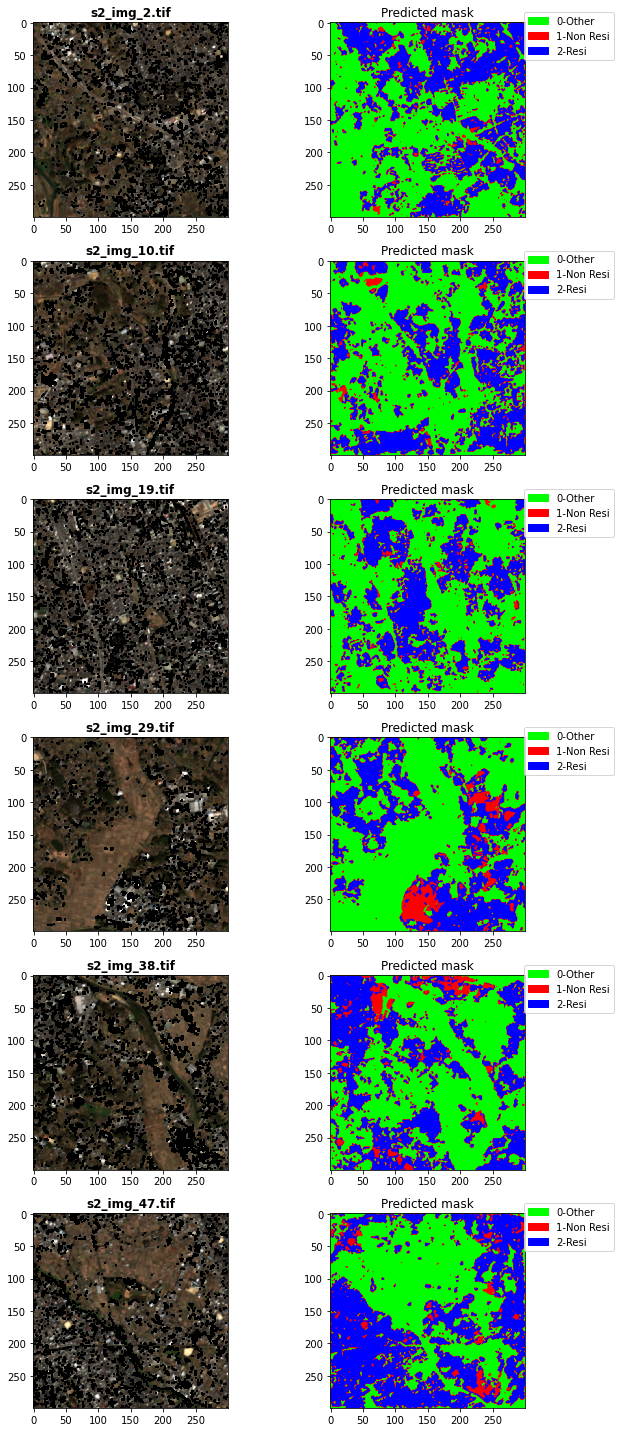

In [16]:
flat2_preds = [x for xs in test2_preds for x in xs]
print(len(test2_images),len(flat2_preds))
plot_predictions(test2_images,flat2_preds,preprocessed_test2_dir,
                 TARGET_PREDS_DIR,cmap=CMAP,code2class=code2class,
                 class2desc=class2desc,show_every=9)

49


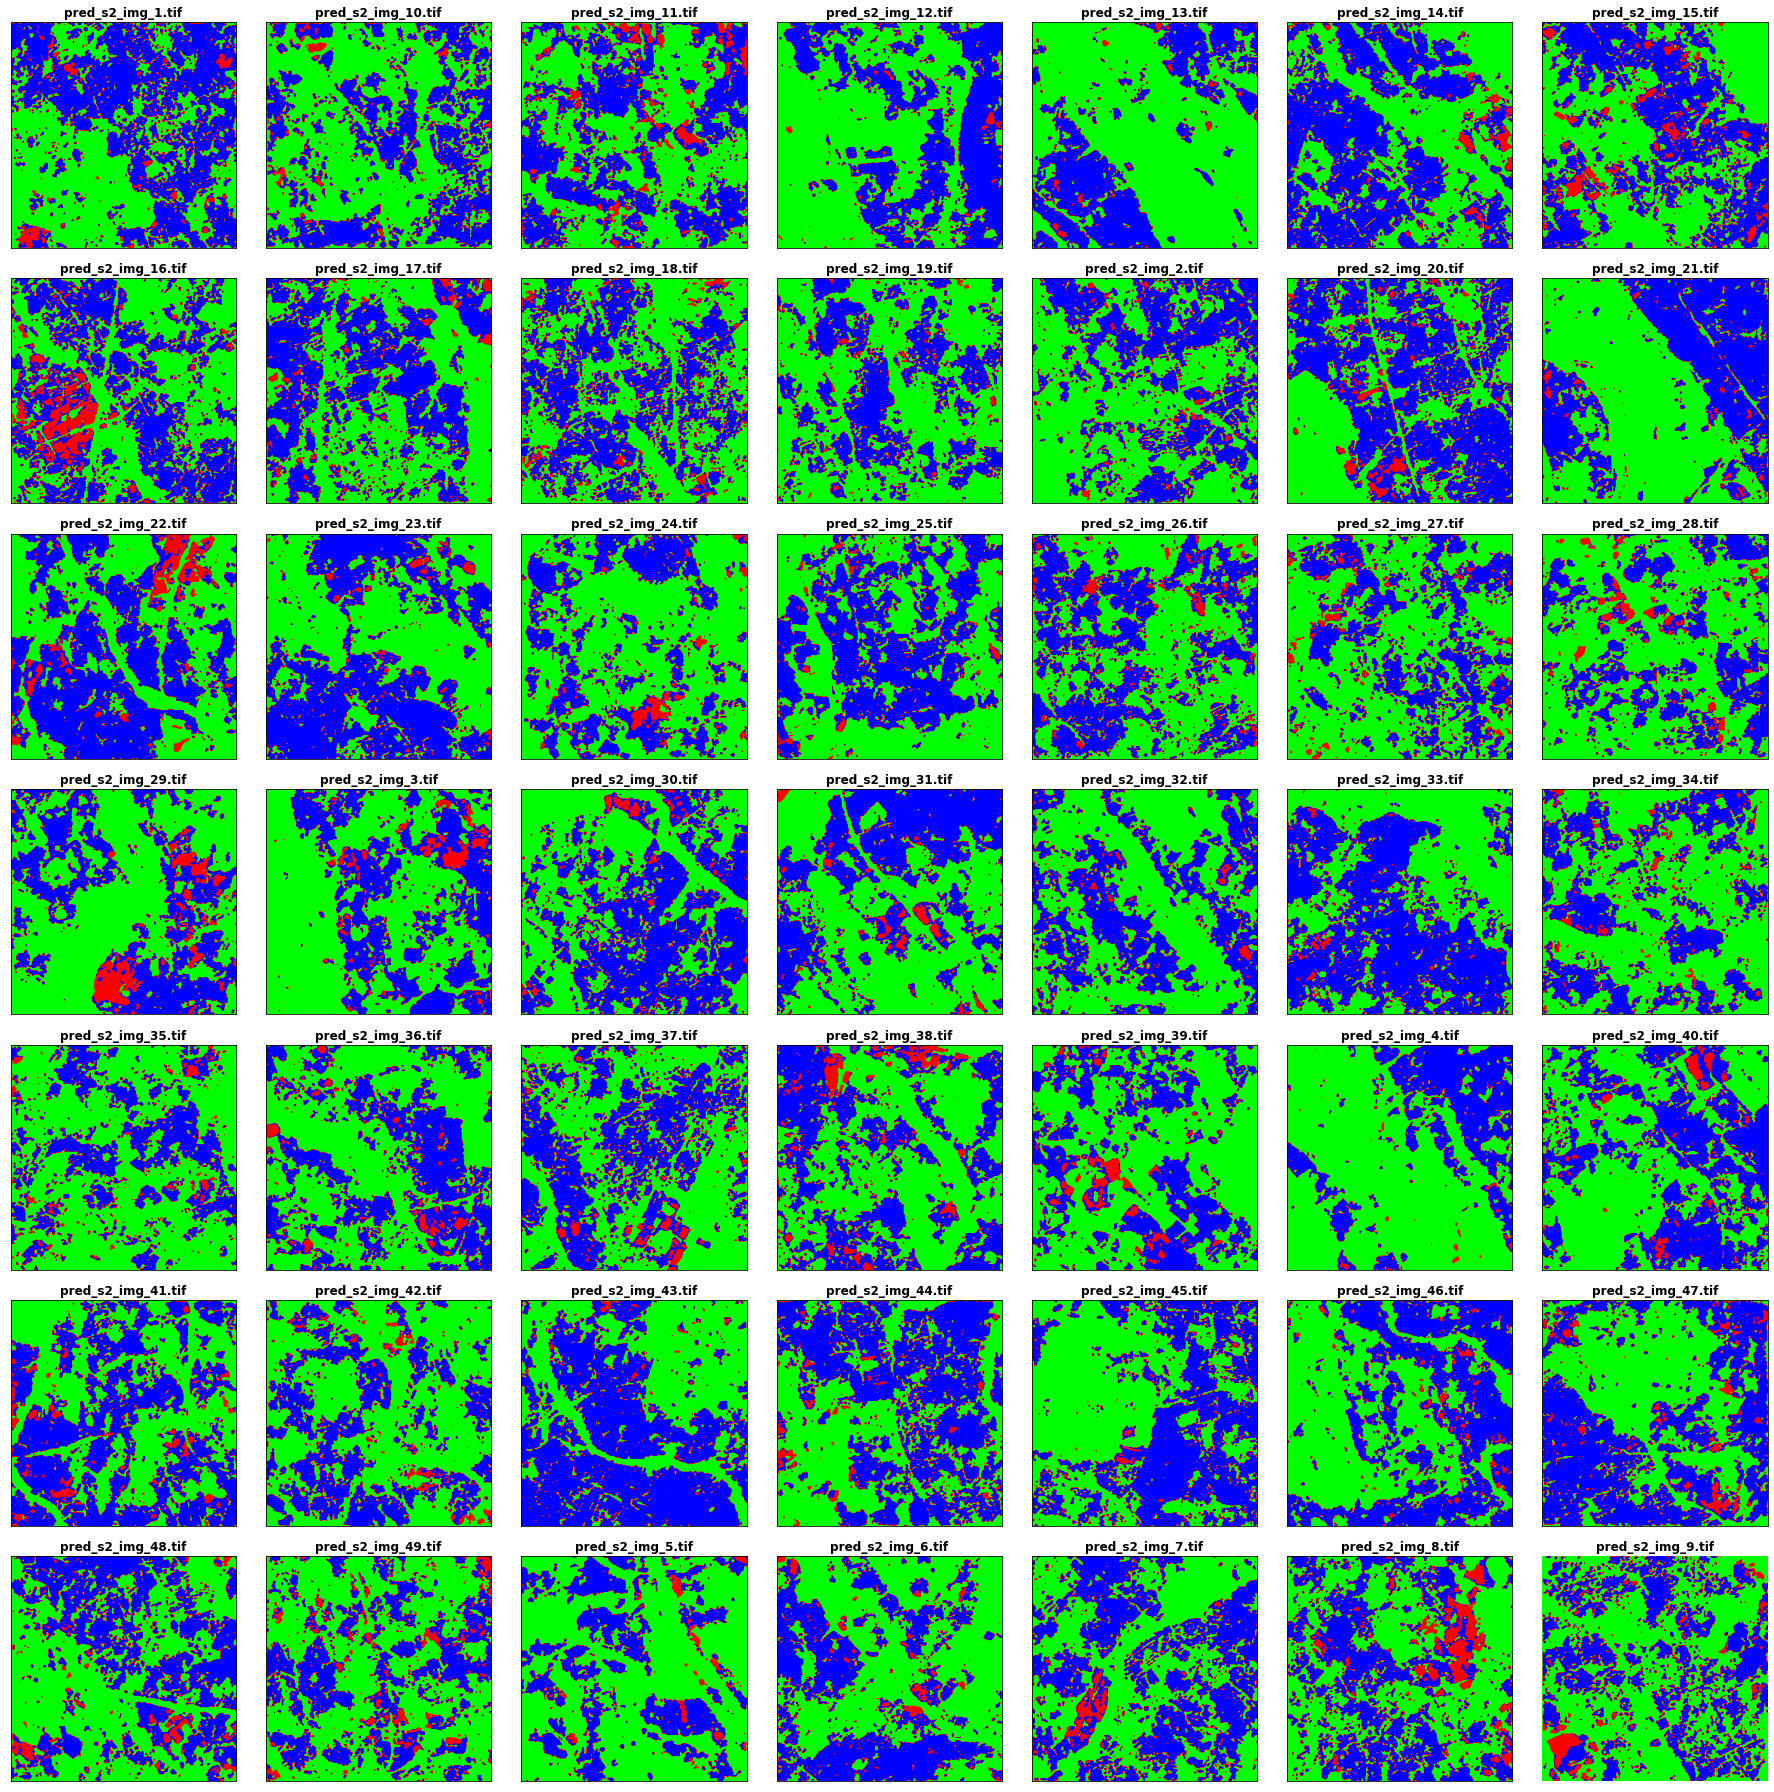

In [17]:
SAITAMA = TARGET_PREDS_DIR
sait = glob.glob(os.path.join(SAITAMA,'*.tif'))
sait = sorted(sait)
print(len(sait))
f,axs = plt.subplots(7,7,figsize=(25,25))
im_no = 0
for i in range(7):
  for j in range(7):
    a = show_image(sait[im_no],bands=[1],cm=CMAP,title='{}'.format(parse_file_name(sait[im_no])),ax=axs[i,j])
    axs[i,j].axes.xaxis.set_visible(False)
    axs[i,j].axes.yaxis.set_visible(False)
    im_no+=1
plt.axis("off")
plt.tight_layout()
plt.show()

In [18]:
if(BACKUP):
  print('Uploading images to:',WORK_DIR)
  !cp -rf {TARGET_PREDS_DIR} WORK_DIR
  !cp -rf {PREDS_DIR} WORK_DIR
print('Predictions saved to:',TARGET_PREDS_DIR)

Predictions saved to: /content/target_preds
